In [1]:
import os, sys
current_dir = os.getcwd()

In [2]:
import os, sys
from __future__ import division
import math
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/dogscatsredux'
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))
#import modules
from utils import *
import vgg16
import vgg16bn


%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
model_path=DATA_HOME_DIR + '/models/'
train_path=path + '/train/'
valid_path=path + '/valid/'
print(os.getcwd())

batch_size=48
no_of_epochs=10

%matplotlib inline

Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5103)
/usr/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


/home/von/bb/fastai/private/dogsvcatsredux/data/dogscatsredux
/home/von/bb/fastai/private/dogsvcatsredux/data/dogscatsredux


In [31]:
## CREATE FROM SCRATCH
vgg = vgg16.Vgg16()
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

## TRAIN
vgg.model.optimizer.lr = 0.01
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

OSError: [Errno 2] No such file or directory: '/home/von/bb/fastai/private/dogsvcatsredux/data/dogscatsredux/data/dogscatsredux//train/'

/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_8 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [4]:
## RECREATE FROM SAVED WEIGHTS
latest = results_path+'ft5.h5'
vgg = recreate(latest)


In [3]:
from sklearn.metrics import confusion_matrix

def recreate(weights_path):
    vgg = vgg16.Vgg16()
    batches = vgg.get_batches(train_path, batch_size=batch_size)
    vgg.finetune(batches)
    vgg.model.load_weights(weights_path)
    return vgg
def recreate_bn(weights_path):
    vgg = vgg16bn.Vgg16BN()
    batches = vgg.get_batches(train_path, batch_size=batch_size)
    vgg.finetune(batches)
    vgg.model.load_weights(weights_path)
    return vgg
def test(vgg, data_path):
    batches, probs = vgg.test(data_path, batch_size = batch_size)
    filenames = batches.filenames
    expected_labels = batches.classes #0 or 1

    #Round our predictions to 0/1 to generate labels
    our_predictions = probs[:,0]
    predicted_labels = np.round(1-our_predictions)
    

    results = {'data': batches, 'filenames' : batches.filenames, 'expected_labels': expected_labels, 'predicted_labels': predicted_labels}
    results['probs'] = probs
    results['data_path'] = data_path
    results['correct'] = np.where(predicted_labels==expected_labels)[0]
    results['incorrect'] = np.where(predicted_labels!=expected_labels)[0]
    results['correct_cats'] = np.where((predicted_labels==0) & (predicted_labels==expected_labels))[0]
    results['correct_dogs'] = np.where((predicted_labels==1) & (predicted_labels==expected_labels))[0]
    results['incorrect_cats'] = np.where((predicted_labels==0) & (predicted_labels!=expected_labels))[0]
    results['incorrect_dogs'] = np.where((predicted_labels==1) & (predicted_labels!=expected_labels))[0]
    results['most_uncertain'] = np.argsort(np.abs(our_predictions-0.5))
    results['cm'] = confusion_matrix(expected_labels, predicted_labels)
    results['accuracy'] = len(results['correct'])/(len(results['correct']) +len(results['incorrect']))
    return results

from PIL import Image
from keras.preprocessing import image
def plots_idx(result, idx, titles=None):
    plots([image.load_img(result['data_path'] + result['filenames'][i]) for i in idx], titles=titles)

In [125]:
results = []
for i in range(10):
    path = results_path+'ft{}.h5'.format(i)
    vgg = recreate(path)
    results.append(test(vgg, valid_path))


Found 2000 images belonging to 2 classes.
/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_48 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
Found 2000 images belonging to 2 classes.
/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_47 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
Found 2000 images belonging to 2 classes.
/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not sp

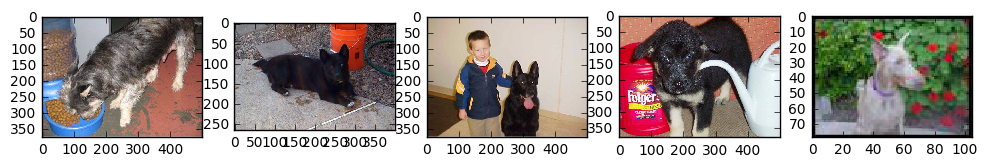

{'learned_cats': [992, 966, 166, 968, 485, 1004, 205, 692, 213, 604, 829, 991], 'learned_dogs': [1888, 1061, 1960, 1387, 1459, 1877]}


In [129]:
best = results[len(results)-1]
worst = results[0]


def confusion_delta(before, after):
    learned_dogs = list(set(before['incorrect_cats']) - set(after['incorrect_cats']))
    learned_cats = list(set(before['incorrect_dogs']) - set(after['incorrect_dogs']))
    return {'learned_cats': learned_cats, 'learned_dogs':learned_dogs}

learned_cats, learned_dogs = confusion_delta(worst, best).values()
print(confusion_delta(worst, best))
plots_idx(best, learned_dogs[:5])

In [57]:
### SEARCH FOR BEST CUTOFFS
def find_best_clip(result, low, high):
    isdog = result['probs'][:,1]
    isdog = isdog.clip(min=low, max=high)
    def lg_loss(yhat, yt):
        return -(yt * np.log(yhat)+(1-yt)*np.log(1-yhat))
    loss = sum([lg_loss(isdog[i], result['expected_labels'][i]) for i in range(len(isdog))])/len(isdog)
    return loss
    
r = result
x = [(l, find_best_clip(r, l, 0.94999996)) for l in np.arange(0.0001, 0.05, 0.001)]
#x = [(l, find_best_clip(r, 0.001, l)) for l in np.arange(0.95, 1.0, 0.001)]
#x = [(i, find_best_clip(l, 0.019, 0.984)) for i, l in enumerate(results)]
print(find_best_clip(r, 0.0001, 0.94999996))
print(find_best_clip(r, 0.019, 0.984))
print(x)
print(min(x, key=lambda x: x[1]))

1.48084110153
2.04409215948
[(0.0001, 1.4808411015285021), (0.0011000000000000001, 1.4813077595926172), (0.0020999999999999999, 1.481781439964831), (0.0030999999999999999, 1.4822584044891256), (0.0041000000000000003, 1.4827378689749906), (0.0051000000000000004, 1.4832190426104694), (0.0061000000000000004, 1.4837020835301484), (0.0071000000000000004, 1.4841862121135025), (0.0080999999999999996, 1.4846713600084418), (0.0091000000000000004, 1.4851577436612047), (0.0101, 1.4856451624245957), (0.011099999999999999, 1.4861336297383334), (0.0121, 1.4866230669867282), (0.013100000000000001, 1.4871135033109601), (0.0141, 1.4876048787067362), (0.015099999999999999, 1.4880972350874464), (0.0161, 1.4885905984640486), (0.017100000000000001, 1.4890848621959814), (0.018100000000000002, 1.4895799654209447), (0.019099999999999999, 1.4900759462816033), (0.0201, 1.490572739801771), (0.021100000000000001, 1.4910705255325343), (0.022099999999999998, 1.4915691159983129), (0.023099999999999999, 1.49206849840

In [32]:
def gen_data(augment=True, batch_size=batch_size):
    if augment:
        gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                                  height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
    else:
        gen = image.ImageDataGenerator()
    val_batches = get_batches(valid_path, shuffle=False, batch_size=batch_size)
    batches = get_batches(train_path, gen, shuffle=True, batch_size=batch_size)
    return batches, val_batches

def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

def split_layers(layers):
    last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]
    conv_layers = layers[:last_conv_idx+1]
    # Dense layers - also known as fully connected or 'FC' layers
    fc_layers = layers[last_conv_idx+1:]
    return conv_layers, fc_layers

def get_ll_layers():
    return [ 
        BatchNormalization(input_shape=(4096,)),
        Dropout(0.5),
        Dense(2, activation='softmax') 
        ]

def get_fc_layers(p, in_shape):
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
        ]

In [0]:
### RETRAIN LAYERS
### WITH DATA AUGMENTATION
latest=results_path+'ft9.h5.finetune2.h5'
retrained=results_path+'ft9.h5.finetune3.h5'
vgg = recreate(latest)
layers = vgg.model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

opt = RMSprop(lr=0.1)
K.set_value(opt.lr, 0.01)

batches, val_batches = gen_data()

#val_data = get_data(val_batches)
#trn_data = get_data(batches)
#val_classes = val_batches.classes
#trn_classes = batches.classes
#val_labels = onehot(val_classes)
#trn_labels = onehot(trn_classes)
#batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
#val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)
fit_model(vgg.model, batches, val_batches, 1)
vgg.model.save_weights(retrained)
fit_model(vgg.model, batches, val_batches, 1)
vgg.model.save_weights(retrained)
fit_model(vgg.model, batches, val_batches, 1)
vgg.model.save_weights(retrained)

In [8]:
vgg = vgg16bn.Vgg16BN()
batches, val_batches = gen_data()
vgg.finetune(batches)
#vgg.model.load_weights(weights_path)
fit_model(vgg.model, batches, val_batches, 1)
vgg.model.save_weights(results_path+'bn_axis0_1.h5')

/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
using updated version
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 354s - loss: 0.2501 - acc: 0.9487 - val_loss: 0.1071 - val_acc: 0.9760

In [27]:
##
## Start bn model from scratch
##
vgg = vgg16bn.Vgg16BN()
batches, val_batches = gen_data(augment=False)
# Replace last layer
vgg.model.pop()
for layer in vgg.model.layers: layer.trainable = False
vgg.model.add(Dense(batches.nb_class, activation='softmax'))
# Split model
conv, dense = split_layers(vgg.model.layers)
conv_model = Sequential(conv)
dense_model = Sequential(dense)
# Precompute conv net results
def precompute(batches, model, file_name, chunk_size):
    #chunk_size = int(math.ceil(batches.nb_sample / chunks))
    for i in range(batches.nb_sample//chunk_size):
        print('chunk {}'.format(i))
        #if i == chunks-1:
            # last chunk. take the rest
        #    chunk_size = min(chunk_size, batches.nb_sample - i*chunk_size)
        features = model.predict_generator(batches, chunk_size)
        if i == 0:
            data = bcolz.carray(features, rootdir=file_name, mode='w')
            data.flush()
        else:
            data.append(features)
            data.flush()
    return data
batches, val_batches = gen_data(augment=False, batch_size=25)
features = precompute(batches, conv_model,  'train_conv', 575)
classes = batches.classes
labels = onehot(classes)
print("Finished!")



Finished!
chunk 39
chunk 38
chunk 37
chunk 36
chunk 35
chunk 34
chunk 33
chunk 32
chunk 31
chunk 30
chunk 29
chunk 28
chunk 27
chunk 26
chunk 25
chunk 24
chunk 23
chunk 22
chunk 21
chunk 20
chunk 19
chunk 18
chunk 17
chunk 16
chunk 15
chunk 14
chunk 13
chunk 12
chunk 11
chunk 10
chunk 9
chunk 8
chunk 7
chunk 6
chunk 5
chunk 4
chunk 3
chunk 2
chunk 1
chunk 0
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
using updated version
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_16 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [28]:
# Also precompute the validation data
batches, val_batches = gen_data(augment=False, batch_size=50)
val_features = precompute(val_batches, conv_model,  'val_conv', 2000)
val_classes = val_batches.classes
val_labels = onehot(val_classes)

chunk 0
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [57]:
%pwd

u'/home/von/bb/fastai/private/dogsvcatsredux/data/dogscatsredux'

In [55]:
#val_features, val_classes, val_labels = precompute(batches, conv_model)
## ...continued
## Train last layer
def train_dense_layers(i, model):
    conv_layers, fc_layers = split_layers(model)
    conv_model = Sequential(conv_layers)
    conv_shape = conv_model.output_shape[1:]
    fc_model = Sequential(get_fc_layers(0.5, conv_shape))
    for l1,l2 in zip(fc_model.layers, fc_layers): 
        weights = l2.get_weights()
        l1.set_weights(weights)
    fc_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', 
                     metrics=['accuracy'])
    fc_model.fit(trn_features, trn_labels, nb_epoch=2, 
         batch_size=batch_size, validation_data=(val_features, val_labels))

    gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.05, 
       width_zoom_range=0.05, zoom_range=0.05,
       channel_shift_range=10, height_shift_range=0.05, shear_range=0.05, horizontal_flip=True)
    batches = gen.flow(trn, trn_labels, batch_size=batch_size)
    val_batches = image.ImageDataGenerator().flow(val, val_labels, 
                      shuffle=False, batch_size=batch_size)

    for layer in conv_model.layers: layer.trainable = False
    for layer in get_fc_layers(0.5, conv_shape): conv_model.add(layer)
    for l1,l2 in zip(conv_model.layers[last_conv_idx+1:], fc_model.layers): 
        l1.set_weights(l2.get_weights())

    conv_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', 
                       metrics=['accuracy'])
    conv_model.save_weights(model_path+'no_dropout_bn' + i + '.h5')
    conv_model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=1, 
                            validation_data=val_batches, nb_val_samples=val_batches.N)
    for layer in conv_model.layers[16:]: layer.trainable = True
    conv_model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=8, 
                            validation_data=val_batches, nb_val_samples=val_batches.N)

    conv_model.optimizer.lr = 1e-7
    conv_model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=10, 
                            validation_data=val_batches, nb_val_samples=val_batches.N)
    conv_model.save_weights(model_path + 'aug' + i + '.h5')
def train_last_precomputed(model, trn_features, trn_labels, val_features, val_labels):

    """Trains the last layer of model starting from the given precalculated features/truths"""
    print("training last")
    model.layers[0] = MaxPooling2D(input_shape=trn_features.shape[2:])
    for layer in model.layers: layer.trainable = False
    model.layers[-1].trainable = True
    model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))
    model.save_weights(model_path+'a1.last.h5')
def train_last(model, batches, val_batches, num_epochs=8):
    """Trains the last layer of model"""
    for layer in model.layers: layer.trainable = False
    model.layers[-1].trainable = True
    model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    fit_model(model, batches, val_batches, num_epochs)
    model.save_weights(model_path+'a1.last.h5')

def train_last_layer(i):
    ll_layers = get_ll_layers()
    ll_model = Sequential(ll_layers)
    ll_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    ll_model.optimizer.lr=1e-5
    ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=12)
    ll_model.optimizer.lr=1e-7
    ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=1)
    ll_model.save_weights(model_path+'ll_bn' + i + '.h5')

    vgg = Vgg16()
    model = vgg.model
    model.pop(); model.pop(); model.pop()
    for layer in model.layers: layer.trainable=False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    ll_layers = get_ll_layers()
    for layer in ll_layers: model.add(layer)
    for l1,l2 in zip(ll_model.layers, model.layers[-3:]):
        l2.set_weights(l1.get_weights())
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save_weights(model_path+'bn' + i + '.h5')
    return model

#train_last(vgg.model, batches, val_batches, 2)
#vgg.model.load_weights(model_path+'a1.last.h5')
model = Vgg16BN().model
train_last_precomputed(dense_model, features, labels, val_features, val_labels)


# model.pop()
# model.pop()
# ll_val_feat = model.predict_generator(val_batches, val_batches.nb_sample)
# ll_feat = model.predict_generator(batches, batches.nb_sample)
# model = train_last_layer(1)


ValueError: Error when checking model input: expected lambda_input_16 to have shape (None, 3, 224, 224) but got array with shape (23000, 512, 14, 14)

using updated version
training last


/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_28 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [9]:
## Train dense layers only

def train_dense_precomputed(model, trn_features, trn_labels, val_features, val_labels):
    """Trains the dense layers of model starting from the given precalculated features/truths"""
    for layer in model.layers:
        if type(layer) is Dense: layer.trainable = True
        else: layer.trainable = False
    model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    #model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))
    fit_model(vgg.model, batches, val_batches, 8)
    model.save_weights(model_path+'a1.dense.h5')
def train_dense(model, batches, val_batches, num_epochs=8, lr=0.001):
    """Trains the dense layers of model"""
    for layer in model.layers:
        if type(layer) is Dense: layer.trainable = True
        else: layer.trainable = False
    model.compile(Adam(lr=lr), 'categorical_crossentropy', metrics=['accuracy'])
    fit_model(model, batches, val_batches, num_epochs)
    model.save_weights(model_path+'a1.dense.h5')


train_dense(vgg.model, batches, val_batches, 1)

## Remove dropout
def set_dropout(model, droprate):
    layers = model.layers
    dropouts = [l for l in layers if type(l) is Dropout]
    denses = [l for l in layers if type(l) is Dense]
    current_droprate = dropouts[0].p
    current_throughrate = 1-current_droprate
    new_throughrate = 1-droprate
    for l in dropouts: l.p = droprate
    for l in denses: l.set_weights([w * current_throughrate / new_throughrate for w in l.get_weights()]) 
set_dropout(vgg.model, 0)
train_dense(vgg.model, batches, val_batches, num_epochs=1, lr=0.0001)

## Add data augmentation
# iteratively train more



/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
using updated version
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 380s - loss: 0.8408 - acc: 0.9399 - val_loss: 0.5682 - val_acc: 0.9590

In [52]:
set_dropout(vgg.model, 0.6)
train_dense(vgg.model, batches, val_batches, num_epochs=1, lr=0.0001)

Epoch 1/1
23000/23000 [==============================] - 380s - loss: 0.0311 - acc: 0.9907 - val_loss: 0.0908 - val_acc: 0.9825

In [53]:
### SAVE FOR KAGGLE
result = test(recreate_bn(model_path+'a1.nodropout.9835.h5'), test_path)
save_array(results_path + 'test_preds.dat', result['probs'])
save_array(results_path + 'filenames.dat', result['filenames'])

/usr/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_7 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
using updated version
Found 23000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [54]:
### RELOAD SAVED TEST DATA
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [56]:
### KAGGLE_PROCESSING
submission_file_name = 'submission5-5.csv'

isdog = preds[:,1]
isdog = isdog.clip(min=0.0001, max=0.94999996)
#Extract imageIds from the filenames in our test/unknown directory
ids = np.array([int(f[8:-4]) for f in filenames])
subm = np.stack([ids,isdog], axis=1)
subm[:5]

np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')